In [1]:
%%capture
!pip install python-doctr
!pip install tensorflow_datasets
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install albumentations==0.4.6
!pip install opencv-python-headless==4.1.2.30
!pip install tensorflow-addons==0.8.3
!pip install tensorflow==2.2.0-rc3
!pip install Pillow==9.0.0
!pip install gluoncv

!git clone https://github.com/facebookresearch/detr.git
!cp -r ./detr/* ./

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image
from doctr.datasets import CORD, SROIE
import albumentations as A
import cv2
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib
from tqdm import tqdm
from gluoncv.utils import bbox_iou
from torchvision.io import read_image
import gc
from pycocotools.coco import COCO

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
matplotlib.rcParams['figure.figsize'] = (10, 8)

In [ ]:
from doctr.datasets import CORD, SROIE

train_set_CORD = CORD(train=True, download=True)
test_set_CORD = CORD(train=False, download=True)
train_set_SROIE = SROIE(train=True, download=True)
test_set_SROIE = SROIE(train=False, download=True)

  0%|          | 0/1633132413 [00:00<?, ?it/s]

  0%|          | 0/214753191 [00:00<?, ?it/s]

  0%|          | 0/289716224 [00:00<?, ?it/s]

  0%|          | 0/172354145 [00:00<?, ?it/s]

In [3]:
IMAGE_SIZE = (1024, 512)

In [4]:
def compute_bbox_iou(golden, output, coco_format=True):
  def convert_to_pascal(targets):
    targets[:, 0] -= targets[:, 2]/2
    targets[:, 1] -= targets[:, 3]/2
    targets[:, 2] += targets[:, 0]
    targets[:, 3] += targets[:, 1]
    return targets

  if coco_format:
    golden = convert_to_pascal(golden)
    output = convert_to_pascal(output)

  return bbox_iou(golden, output).max(axis=1).mean()  

In [5]:
def plot_results(pil_img, annotations, denormalize=True, format='pascal'):
    boxes = annotations['boxes'] if isinstance(outputs, dict) else annotations
    labels = annotations['labels'] if 'labels' in annotations.keys() else None

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = [(1,0,0), (1,1,0),(0,1,0),(0,0,1)]
    if denormalize:
        boxes = A.augmentations.bbox_utils.denormalize_bboxes(boxes, rows=pil_img.shape[0], cols=pil_img.shape[1])

    if format == 'yolo':
      for (x_center, y_center, width, height)  in boxes:
        x_min = x_center - width/2 
        y_min = y_center - height/2
        ax.add_patch(plt.Rectangle((x_min, y_min), width, height,
                                    fill=False, color=(1,0,0), linewidth=1))
    elif format == 'coco':
      for i, (x_min, y_min, width, height) in enumerate(boxes):
        color = (1,0,0) if labels == None else colors[labels[i]-1]

        ax.add_patch(plt.Rectangle((x_min, y_min), width, height,
                                    fill=False, color=color, linewidth=1))
    elif format == 'pascal':
      for (xmin, ymin, xmax, ymax) in boxes:
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=(1,0,0), linewidth=1))
    plt.axis('off')
    plt.savefig('plot_results.png')
    plt.show()

In [140]:
class Custom_COCO_Dataset(Dataset):
  def __init__(self, image_directory, annotation_file, transform, denormalize=False):
    self.image_directory = image_directory
    self.coco = COCO(annotation_file)
    self.image_ids = self.coco.getImgIds()
    self.transform = transform
    self.denormalize = denormalize

  def __len__(self):
    return len(self.image_ids)

  def scan_annotations(self, annotations): 
    boxes = []
    targets = []
    area = []
    for annotation in annotations:
      boxes.append(annotation['bbox'])
      targets.append(annotation['category_id'])
      area.append(annotation['area'])
    
    return boxes, targets, area

  def __getitem__(self, idx):
    image_data = self.coco.loadImgs(self.image_ids[idx])[0]
    image = np.array(Image.open(self.image_directory + image_data['file_name']).convert('RGB'))
    annotation_ids = self.coco.getAnnIds(imgIds=image_data['id'], iscrowd=None)
    boxes, labels, areas = self.scan_annotations(self.coco.loadAnns(annotation_ids))
    boxes_new = None

    if self.transform and image.shape[2] > 1:
      sample = self.transform(image=image, bboxes=boxes, labels=labels)
      image_new = sample['image']
      boxes_new = sample['bboxes']
      labels_new = sample['labels']
    else:
      image_new = torch.as_tensor(image).permute(2,0,1)
      boxes_new = boxes
      labels_new = labels

    if boxes_new == None:
      boxes_new = boxes

    if self.denormalize:
      boxes_new = A.augmentations.bbox_utils.denormalize_bboxes(boxes_new, 
                                                                rows=IMAGE_SIZE[0], 
                                                                cols=IMAGE_SIZE[1])

    area = torch.as_tensor(np.abs(areas), dtype=torch.float32)
    iscrowd = torch.zeros((len(boxes_new),), dtype=torch.int64)
    
    targets = {}
    targets['iscrowd'] = iscrowd
    targets['image_id'] = torch.tensor([idx])
    targets['boxes'] = torch.as_tensor(boxes_new, dtype=torch.float32)
    targets['labels'] = torch.as_tensor(labels_new, dtype=torch.long)-1
    targets['area'] = area

    return image_new.to(torch.float32), targets

class Custom_Dataset(Dataset):
  def __init__(self, dataset, transform, denormalize=False, coco_format=True):
    self.dataset = dataset
    self.transform = transform
    self.denormalize = denormalize
    self.coco_format = coco_format

  def __len__(self):
    return len(self.dataset)

  def convert_COCO(self, boxes):
    for i in range(len(boxes)):
      xmin, ymin, xmax, ymax = boxes[i]
      x_center = 0.5 * (xmin + xmax)
      y_center = 0.5 * (ymin + ymax)
      width = np.abs(xmax - xmin)
      height = np.abs(ymax - ymin)
      boxes[i] = (x_center, y_center, width, height) 
    return boxes

  def __getitem__(self, idx):
    image, boxes = self.dataset[idx]
    image = image.numpy()
    boxes = boxes['boxes']
    labels = np.zeros(len(boxes), dtype=np.int32)
    boxes_new = None

    if self.transform:
      while boxes_new == None or len(boxes_new) == 0: 
        sample = self.transform(image=image, bboxes=boxes, labels=labels)
        image_new = sample['image']
        boxes_new = sample['bboxes']
        labels_new = sample['labels']
    
    if boxes_new == None:
      boxes_new = boxes
    if self.denormalize:
      boxes_new = A.augmentations.bbox_utils.denormalize_bboxes(boxes_new, 
                                                                rows=IMAGE_SIZE[0], 
                                                                cols=IMAGE_SIZE[1])

    area = np.abs((boxes[:,0] - boxes[:,2]) * (boxes[:,1] - boxes[:,3]))
    area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((len(boxes_new),), dtype=torch.int64)
    targets = {}
    targets['iscrowd'] = iscrowd
    targets['image_id'] = torch.tensor([idx])
    if self.coco_format:
      targets['boxes'] = torch.as_tensor(self.convert_COCO(boxes_new), dtype=torch.float32)
    else:
      targets['boxes'] = torch.as_tensor(boxes_new, dtype=torch.float32)
    targets['labels'] = torch.as_tensor(labels_new, dtype=torch.long)
    targets['area'] = area

    return image_new, targets

In [136]:
def get_train_transforms(format='albumentations', crop_probability=0.5):
    return A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.75),
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75)], p=0.75),
                      A.ToGray(p=1.0),
                      A.Rotate(p=0.5, limit=5),
                      A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=1),
                      A.RandomSizedCrop(min_max_height=(450, 512), height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=crop_probability),
                      ToTensorV2(p=1.0)],
                      p=1.0, 
                      bbox_params=A.BboxParams(format=format, min_area=1, label_fields=['labels'])
                      )

def get_val_transforms(format='albumentations'):
    return A.Compose([
                      A.ToGray(p=1.0),
                      A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1], p=1),
                      ToTensorV2(p=1.0)],
                      p=1.0, 
                      bbox_params=A.BboxParams(format=format, min_area=0, label_fields=['labels'])
    )

In [8]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(1, len(train_losses.keys), figsize=(len(train_losses.keys)*6, 5))
    
    for i, key in enumerate(train_losses.keys):
      axs[i].plot(range(1, len(train_losses) + 1), train_losses.loss[key], label=f'Train {key}')
      axs[i].plot(range(1, len(test_losses) + 1), test_losses.loss[key], label=f'Test {key}')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc = "upper right")
    plt.savefig('losses.png')
    plt.show()

In [9]:
class Loss:
  def __init__(self, keys):
    self.loss = {}
    self.keys = keys
    for key in self.keys:
      self.loss[key] = []
  
  def update(self, new_loss_dict):
    for key in self.keys:
      self.loss[key].append(new_loss_dict[key].item())
  
  def __len__(self):
    return len(self.loss[self.keys[0]])

  def compute(self):
    return_loss = {}
    for key in self.keys:
      return_loss[key] = np.mean(self.loss[key])
    return return_loss

  def print(self):
    for i in range(len(self.keys)):
      last = ' | ' if i < len(self.keys)-1 else '\n'
      key_name = self.keys[i]
      print(key_name.upper(), ': %.3f' % np.mean(self.loss[self.keys[i]]),sep='', end=last)

## ResNET

In [ ]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 150048, done.
remote: Counting objects: 100% (2424/2424), done.
remote: Compressing objects: 100% (355/355), done.
remote: Total 150048 (delta 2089), reused 2332 (delta 2060), pack-reused 147624
Receiving objects: 100% (150048/150048), 293.30 MiB | 16.48 MiB/s, done.
Resolving deltas: 100% (132679/132679), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import evaluate, train_one_epoch

In [ ]:
LR = 1e-5
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()

train_dataset = Custom_Dataset(train_set_CORD, train_transforms, denormalize=True, coco_format=False)
val_dataset = Custom_Dataset(test_set_CORD, val_transforms, denormalize=True, coco_format=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=False)

In [ ]:
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def compute_iou(model, dataloader, device):
  model.eval()
  iou = []
  for step, (images, targets) in enumerate(dataloader):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    output = model(list(images))
    for i in range(len(targets)):
      if output[i]['boxes'].shape[0] > 0:
        iou.append(compute_bbox_iou(targets[i]['boxes'].detach().cpu().numpy(), output[i]['boxes'].detach().cpu().numpy(), coco_format=False))

  return np.mean(iou)

In [ ]:
model.to(device)

for epoch in range(EPOCHS):
  train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=5)
  scheduler.step()
  evaluate(model, val_dataloader, device)
  print('Mean IOU: ', compute_iou(model, val_dataloader, device))

Epoch: [0]  [ 0/13]  eta: 0:01:33  lr: 0.000001  loss: 1.7434 (1.7434)  loss_classifier: 0.7187 (0.7187)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.8563 (0.8563)  loss_rpn_box_reg: 0.1684 (0.1684)  time: 7.2250  data: 6.1193  max mem: 11103
Epoch: [0]  [ 5/13]  eta: 0:00:56  lr: 0.000005  loss: 1.7442 (1.7544)  loss_classifier: 0.6778 (0.6740)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.8705 (0.8879)  loss_rpn_box_reg: 0.1888 (0.1925)  time: 7.0302  data: 5.8869  max mem: 11103
Epoch: [0]  [10/13]  eta: 0:00:20  lr: 0.000009  loss: 1.6877 (1.5969)  loss_classifier: 0.6302 (0.6053)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.8563 (0.7998)  loss_rpn_box_reg: 0.1935 (0.1918)  time: 6.7626  data: 5.5599  max mem: 11103
Epoch: [0]  [12/13]  eta: 0:00:06  lr: 0.000010  loss: 1.5239 (1.5267)  loss_classifier: 0.6023 (0.5713)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.7209 (0.7635)  loss_rpn_box_reg: 0.1929 (0.1919)  time: 6.6422  data: 5.4495  max mem: 11103
Epoc

KeyboardInterrupt: ignored

## DETR

In [10]:
def train_one_epoch(data_loader, model, criterion, optimizer, device, scheduler, epoch, losses_names, display_step=10):
    model.train()
    criterion.train()
    loss = Loss(losses_names)

    for step, (images, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        output = model(list(images))
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        losses.backward()
        optimizer.step()
        
        loss.update(loss_dict)

        if scheduler is not None:
            scheduler.step()

        if not step % display_step:
            print('Train: %.1f' % (step/len(data_loader) * 100), end='% | ')
            print('EPOCH:', epoch, end= ' | ')
            print('LR:', optimizer.param_groups[0]['lr'], end= ' | ')
            loss.print()
    
    return loss.compute()

def evaluate(data_loader, model, criterion, optimizer, device, scheduler, epoch, losses_names, display_step=10):
    model.eval()
    criterion.eval()
    loss = Loss(losses_names)
    iou = []

    for step, (images, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(list(images))
        loss_dict = criterion(output, targets)
        
        loss.update(loss_dict)
        mean_iou = compute_bbox_iou(targets[0]['boxes'].detach().cpu().numpy(), model(list(images))['pred_boxes'][0].detach().cpu().numpy())
        iou.append(mean_iou)

        if not step % display_step:
            print('Evaluate: %.1f' % (step/len(data_loader) * 100), end='% | ')
            print('EPOCH:', epoch, end= ' | ')
            print('LR:', optimizer.param_groups[0]['lr'], end= ' | ')
            print('MEAN_IOU:', np.mean(iou), end= ' | ')
            loss.print()

    return loss.compute(), np.mean(iou)

In [11]:
class DETRModel(nn.Module):
    def __init__(self, num_queries=100, num_classes=2, freeze_backbone=False, pretrained=True):
        super(DETRModel, self).__init__()
        self.num_queries = num_queries
        self.num_classes = num_classes
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=pretrained)
        self.in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        self.model.backbone.requires_grad_(not freeze_backbone)
        
    def forward(self, images):
        return self.model(images)

In [70]:
model = DETRModel(freeze_backbone=False, pretrained=True, num_queries=40)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


In [ ]:
sum(p.numel() for p in model.model.parameters() if p.requires_grad)

41501638

In [71]:
LR = 1e-5
EPOCHS = 16
BATCH_SIZE = 8

In [69]:
train_transforms = get_train_transforms()
val_transforms = get_val_transforms()

train_dataset = Custom_Dataset(train_set_SROIE, train_transforms)
val_dataset = Custom_Dataset(test_set_SROIE, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=False)

In [29]:
image, target = train_dataset[0]

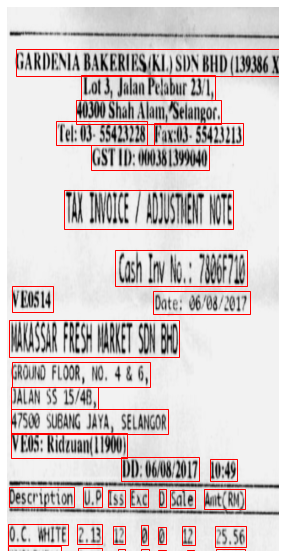

In [30]:
plot_results(image.permute(1,2,0), target, format='yolo')

In [72]:
matcher = HungarianMatcher()
weight_dict = {'loss_ce': 1, 'loss_bbox': 1, 'loss_giou': 2} 
losses = ['labels', 'boxes', 'cardinality']

criterion = SetCriterion(1, matcher, weight_dict, eos_coef=0.5, losses=losses)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [46]:
list(criterion.weight_dict.keys())

['loss_ce', 'loss_bbox', 'loss_giou']

In [88]:
gc.collect()
torch.cuda.empty_cache()

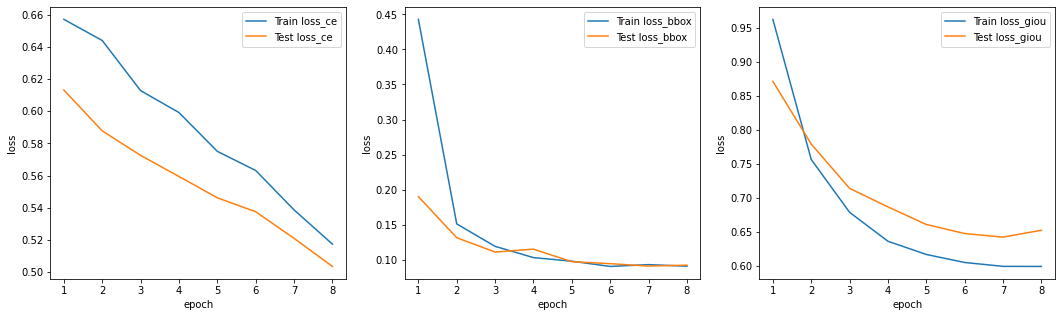

Mean IOU on 8 epoch: 0.43838801980018616
Train: 0.0% | EPOCH: 9 | LR: 1.25e-06 | LOSS_CE: 0.540 | LOSS_BBOX: 0.098 | LOSS_GIOU: 0.586
Train: 12.7% | EPOCH: 9 | LR: 1.25e-06 | LOSS_CE: 0.513 | LOSS_BBOX: 0.091 | LOSS_GIOU: 0.595
Train: 25.3% | EPOCH: 9 | LR: 1.25e-06 | LOSS_CE: 0.515 | LOSS_BBOX: 0.091 | LOSS_GIOU: 0.598


KeyboardInterrupt: ignored

In [74]:
model.to(device)
criterion.to(device)

loss_names = list(criterion.weight_dict.keys())[:3]
train_losses = Loss(loss_names)
eval_losses = Loss(loss_names)

for epoch in range(1, EPOCHS+1):
  train_losses.update(train_one_epoch(train_dataloader, model, criterion, optimizer, device, scheduler, epoch, loss_names))  
  gc.collect()
  torch.cuda.empty_cache()
  loss, iou = evaluate(val_dataloader, model, criterion, optimizer, device, scheduler, epoch, loss_names, display_step=len(val_dataloader)/20)
  eval_losses.update(loss)
  plot_losses(train_losses, eval_losses)
  print(f'Mean IOU on {epoch} epoch: {iou}')

In [113]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/coursework/DETR_SROIE_8_epoch.pth')

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [76]:
val_dataloader_1 = DataLoader(val_dataset, batch_size=8, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True)
images, targets = next(iter(val_dataloader_1))
model.to('cpu')
outputs = model(list(images))

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


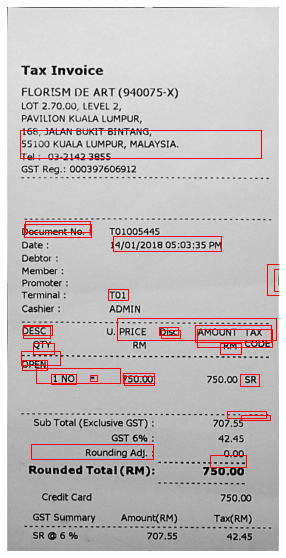

In [97]:
idx = 7
prob = outputs['pred_logits'][idx].softmax(1).detach().cpu().numpy()[:,1]
plot_results(images[idx].permute(1,2,0), outputs['pred_boxes'][idx][np.where(prob > 0.5)].cpu().detach().numpy(), format='yolo')

## Тренировка на собственном датасете

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
LR = 1e-5
EPOCHS = 20
BATCH_SIZE = 8

In [141]:
image_directory_train = '/content/drive/MyDrive/custom/train2017/'
image_directory_val = '/content/drive/MyDrive/custom/val2017/'
annotation_file_train = '/content/drive/MyDrive/custom/annotations/instances_train2017.json'
annotation_file_val = '/content/drive/MyDrive/custom/annotations/instances_val2017.json'

train_transforms = get_train_transforms(format='coco', crop_probability=0)
val_transforms = get_val_transforms(format='coco')

train_dataset = Custom_COCO_Dataset(image_directory_train, annotation_file_train, train_transforms)
val_dataset = Custom_COCO_Dataset(image_directory_val, annotation_file_val, val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=lambda batch: tuple(zip(*batch)), shuffle=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [130]:
model = DETRModel(num_classes = 5, freeze_backbone=False, pretrained=True, num_queries=40)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


In [148]:
model = torch.load('/content/drive/MyDrive/Colab Notebooks/coursework/DETR_(SROIE).pth') # DETR дообученный на SROIE
model.model.class_embed = nn.Linear(in_features=model.model.class_embed.in_features, out_features=5)

In [150]:
matcher = HungarianMatcher()
weight_dict = {'loss_ce': 1, 'loss_bbox': 1, 'loss_giou': 1} 
losses = ['labels', 'boxes', 'cardinality']

criterion = SetCriterion(4, matcher, weight_dict, eos_coef=0.5, losses=losses)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

In [145]:
gc.collect()
torch.cuda.empty_cache()

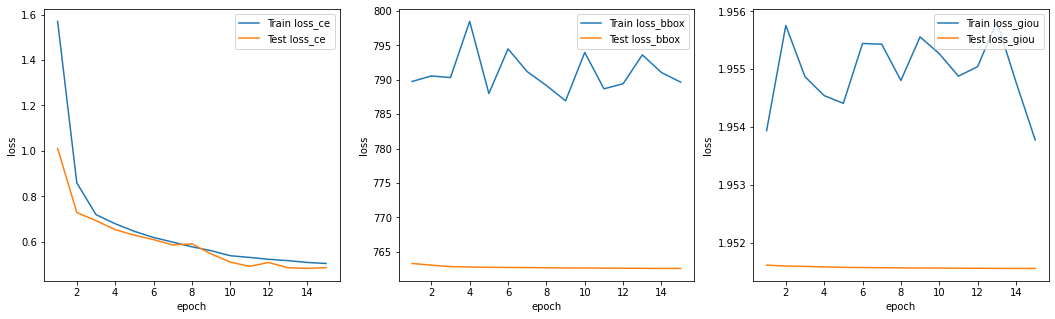

Mean IOU on 15 epoch: 7.556432990440953e-08
Train: 0.0% | EPOCH: 16 | LR: 1.25e-06 | LOSS_CE: 0.540 | LOSS_BBOX: 907.200 | LOSS_GIOU: 1.955
Train: 28.6% | EPOCH: 16 | LR: 1.25e-06 | LOSS_CE: 0.479 | LOSS_BBOX: 804.843 | LOSS_GIOU: 1.957
Train: 57.1% | EPOCH: 16 | LR: 1.25e-06 | LOSS_CE: 0.472 | LOSS_BBOX: 781.120 | LOSS_GIOU: 1.957
Train: 85.7% | EPOCH: 16 | LR: 1.25e-06 | LOSS_CE: 0.503 | LOSS_BBOX: 793.762 | LOSS_GIOU: 1.954


In [ ]:
model.to(device)
criterion.to(device)

loss_names = list(criterion.weight_dict.keys())
train_losses = Loss(loss_names)
eval_losses = Loss(loss_names)

for epoch in range(1, EPOCHS+1):
  train_losses.update(train_one_epoch(train_dataloader, model, criterion, optimizer, device, scheduler, epoch, loss_names))  
  gc.collect()
  torch.cuda.empty_cache()
  loss, iou = evaluate(val_dataloader, model, criterion, optimizer, device, scheduler, epoch, loss_names, display_step=len(val_dataloader)/20)
  eval_losses.update(loss)
  plot_losses(train_losses, eval_losses)
  print(f'Mean IOU on {epoch} epoch: {iou}')